In [132]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import imghdr

In [133]:
import cv2

In [134]:
data_dir = "data"
image_extensions = ["jpeg", "jpg", "bmp", "png"] #List of allowed extensions

In [135]:
os.listdir(data_dir)

['Dogs', 'Cats']

In [136]:
cv2.imread(os.path.join(data_dir, "Dogs", "1752573485303.jpeg")).shape
#height, width, no_clr_channels
#This is 46 pixels high 69 pixels wide

(46, 69, 3)

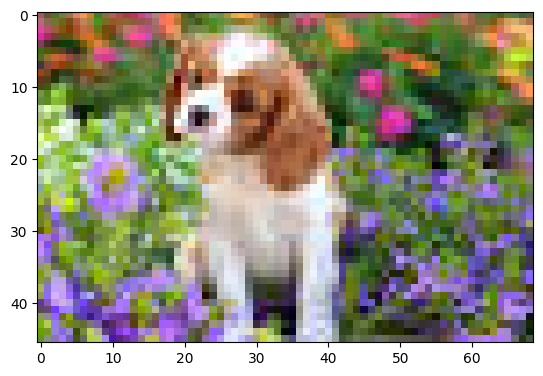

In [137]:
img = cv2.imread(os.path.join("data", "Dogs", "1752573485303.jpeg"))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
#opencv uses bgr and matplotlib expects rgb so we are converting
plt.show()

In [138]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_extensions: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)



Loading our data

In [139]:
data = tf.keras.utils.image_dataset_from_directory("data")
#Builds us the dataset and does some preprocessing

Found 132 files belonging to 2 classes.


In [140]:
#The data is a generator so we will convert it to a numpy iterator
data_iterator = data.as_numpy_iterator()
#We will get consecutive batches from .next()

In [141]:
batch = data_iterator.next()
batch

(array([[[[ 11.       ,  18.       ,   2.       ],
          [ 11.       ,  18.       ,   2.       ],
          [ 11.       ,  18.       ,   2.       ],
          ...,
          [ 27.794922 ,  31.794922 ,   6.794922 ],
          [ 28.876953 ,  32.876953 ,   7.876953 ],
          [ 29.958984 ,  33.958984 ,   8.958984 ]],
 
         [[ 11.       ,  18.       ,   2.       ],
          [ 11.       ,  18.       ,   2.       ],
          [ 11.       ,  18.       ,   2.       ],
          ...,
          [ 28.361328 ,  32.36133  ,   7.361328 ],
          [ 29.44336  ,  33.44336  ,   8.443359 ],
          [ 30.52539  ,  34.52539  ,   9.525391 ]],
 
         [[ 11.       ,  17.722656 ,   2.2773438],
          [ 11.       ,  17.756783 ,   2.2432175],
          [ 11.       ,  18.       ,   2.       ],
          ...,
          [ 29.129143 ,  33.129143 ,   8.129143 ],
          [ 30.154297 ,  34.154297 ,   9.154297 ],
          [ 31.236328 ,  35.23633  ,  10.236328 ]],
 
         ...,
 
         [[ 

In [142]:
len(batch) #the images and the labels


2

In [143]:
batch[0].shape #We have to index the 0 as we want the shape of the images batch[1] wil refer to the labels

(32, 256, 256, 3)

In [144]:
batch[1]

array([0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 1, 0], dtype=int32)

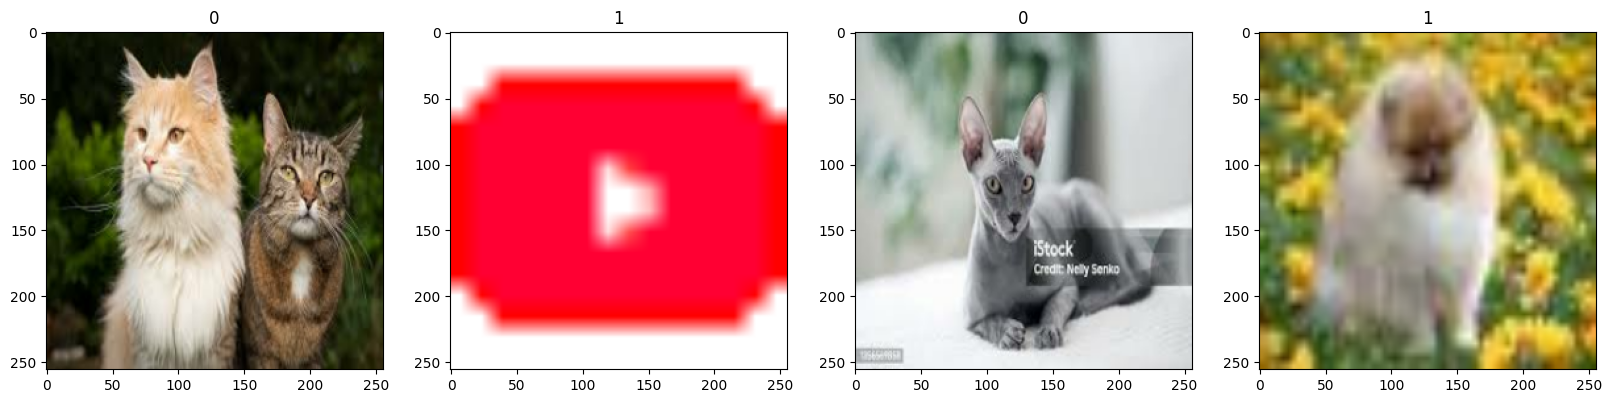

In [145]:
fig, ax = plt.subplots(ncols = 4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Preprocessing our data

In [146]:
data = data.map(lambda x,y: (x/255, y))
#Every time we fetch our data from the pipeline, it will scale our data between 0 and 1

In [147]:
scaled_iterator = data.as_numpy_iterator()
batch = scaled_iterator.next()

In [153]:
batch[0].max()

np.float32(1.0)

Splitting our data 

In [154]:
len(data) #5 batches

5

In [155]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1) + 1 #Adding a one so all batches are used

train_size, val_size, test_size

(3, 1, 1)

In [156]:
#Our data has already been shuffled so we aren't shuffling it here
train_data = data.take(train_size)
val_data = data.skip(train_size).take(val_size)
test_data = data.skip(train_size + val_size).take(test_size)

In [157]:
len(train_data), len(val_data), len(test_data)

(3, 1, 1)

Building the deep learning model

In [177]:
model = tf.keras.Sequential()

In [178]:
#16 filters, kernal_size = (3,3) stride = 1, stride is how many pixels it moves over at once
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation="relu", input_shape=(256,256,3)))
model.add(tf.keras.layers.MaxPooling2D()) #returns back the max value that we get from our convolution

model.add(tf.keras.layers.Conv2D(32, (3,3), 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation="relu"))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation="relu"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

/home/varshaan/image-classification/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [179]:
model.compile("adam", loss = tf.losses.BinaryCrossentropy(), metrics=["accuracy"])

In [180]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [181]:
logdir = "logs"

In [182]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [183]:
history = model.fit(train_data, epochs = 60, validation_data= val_data, callbacks=[tensorboard_callback])

Epoch 1/60


3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.5690 - loss: 1.0980 - val_accuracy: 0.4375 - val_loss: 1.1775
Epoch 2/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step - accuracy: 0.5599 - loss: 0.8422 - val_accuracy: 0.5938 - val_loss: 0.6656
Epoch 3/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - accuracy: 0.6224 - loss: 0.6468 - val_accuracy: 0.6875 - val_loss: 0.6262
Epoch 4/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step - accuracy: 0.5534 - loss: 0.6643 - val_accuracy: 0.8125 - val_loss: 0.5648
Epoch 5/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.6758 - loss: 0.6209 - val_accuracy: 0.5938 - val_loss: 0.6405
Epoch 6/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.6992 - loss: 0.6052 - val_accuracy: 0.5625 - val_loss: 0.6294
Epoch 7/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.6849 - loss: 0.6162 - val_accuracy: 0.7188 - val_loss: 0.5264
Epoch 8/60
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step - accuracy: 0.6979 - loss: 0.5779 - val_accuracy: 0.7188 - val_loss: 0.5662
Epo

In [184]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

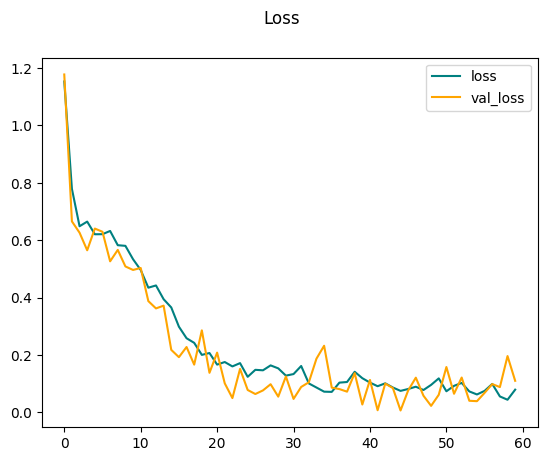

In [185]:
fig = plt.figure()
plt.plot(history.history["loss"], color="teal", label="loss")
plt.plot(history.history["val_loss"], color="orange", label="val_loss")
fig.suptitle("Loss")
plt.legend()
plt.show()

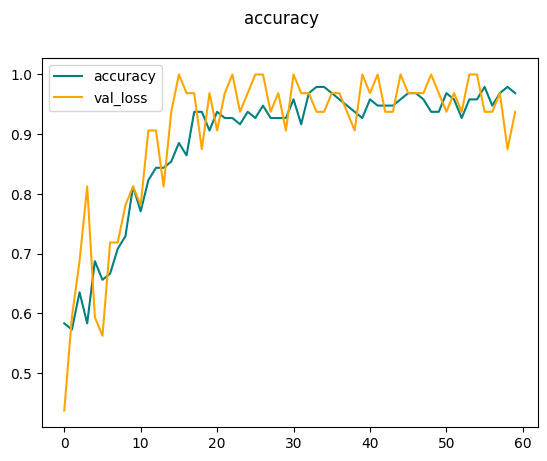

In [187]:
fig = plt.figure()
plt.plot(history.history["accuracy"], color="teal", label="accuracy")
plt.plot(history.history["val_accuracy"], color="orange", label="val_loss")
fig.suptitle("accuracy")
plt.legend()
plt.show()

In [188]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [189]:
precision = Precision()
recall = Recall()
acc = BinaryAccuracy()

In [190]:
len(test)

1

In [191]:
for batch in test.as_numpy_iterator():
    X, y = batch
    y_pred = model.predict(X)
    precision.update_state(y, y_pred)
    recall.update_state(y, y_pred)
    acc.update_state(y, y_pred)

    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


2025-07-15 12:55:05.873096: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [193]:
print("precision:", precision.result().numpy(), "recall", recall.result().numpy(), "acc", acc.result().numpy())

precision: 1.0 recall 1.0 acc 1.0
